In [112]:
import sys
sys.path.append("/usr/local/lib/python3.8/site-packages/")

In [113]:
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from pprint import pprint
import scipy
from cvxpy import *
from IPython.display import clear_output

In [114]:
N = 8

In [115]:
np.set_printoptions(suppress=True)

画素
[[139 144 149 153 155 155 155 155]
 [144 151 153 156 159 156 156 156]
 [150 155 160 163 158 156 156 156]
 [159 161 162 160 160 159 159 159]
 [159 161 162 162 162 155 155 155]
 [161 161 161 161 160 157 157 157]
 [162 162 161 163 162 157 157 157]
 [162 162 161 161 163 158 158 158]]
画像


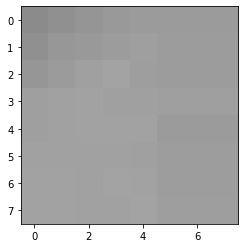

In [116]:
img_test = np.array([
    [139,144,149,153,155,155,155,155],
    [144,151,153,156,159,156,156,156],
    [150,155,160,163,158,156,156,156], 
    [159,161,162,160,160,159,159,159],
    [159,161,162,162,162,155,155,155],
    [161,161,161,161,160,157,157,157],
    [162,162,161,163,162,157,157,157],
    [162,162,161,161,163,158,158,158]
])
print("画素")
print(img_test)
print("画像")
plt.imshow(img_test,vmin=0, vmax=255)
plt.gray()
plt.show()

In [117]:
class JPEG:
    def __init__(self,N):
        self.quantizer_table = \
             np.array([ 16, 11, 10, 16,  24,  40,  51,  61,
                        12, 12, 14, 19,  26,  58,  60,  55,
                        14, 13, 16, 24,  40,  57,  69,  56,
                        14, 17, 22, 29,  51,  87,  80,  62,
                        18, 22, 37, 56,  68, 109, 103,  77,
                        24, 35, 55, 64,  81, 104, 113,  92,
                        49, 64, 78, 87, 103, 121, 120, 101,
                        72, 92, 95, 98, 112, 100, 103,  99 ])
        
        self.N = N
        self.phi = np.array([self.phi_k(k) for k in range(N)])
        self.sparse_num = 0
        
    def phi_k(self,k):
        if k == 0:
            return np.ones(self.N) / math.sqrt(self.N)
        else:
            return math.sqrt(2/self.N)*np.cos(((2*(np.arange(self.N))+1)*k*math.pi)/(2*self.N))
    
    def convertToJPEG(self,img,is_quantize=True):
        img -= 128
        image_list = []
        x,y = img.shape
        if x %8 != 0 or y %8 != 0:
            print("Error : image must be square, and its size must be divided 8")
            return -1
        
        for i in range(y//8):
            for j in range(x//8):
                im = img[self.N*i:self.N*(i+1),self.N*j:self.N*(j+1)]
                image_list.append(im)


        for i in range(y//8):
            for j in range(x//8):
                if is_quantize == True:
                    converted_img = self.convert(image_list[i*80+j])
                else:
                    converted_img = self.convert_no_quantize(image_list[i*80+j])
                if j == 0:
                    pre_coef = converted_img
                else:
                    pre_coef = np.concatenate([pre_coef, converted_img], 1)
            if i == 0:
                restored_img = pre_coef
            else:
                restored_img = np.concatenate([restored_img,  pre_coef])
        
        restored_img = restored_img.astype(dtype=int)
        correct_abnormal_value(restored_img)
        return restored_img

    def convert(self,img):
        dct_coef = self.dct(img)
        quantized_dct = self.quantize(dct_coef)

        self.sparse_num += quantized_dct.size-np.count_nonzero(quantized_dct)
        inv_quantized_dct = self.inv_quantize(quantized_dct)

        inv_quantized_dct = np.array(np.split(inv_quantized_dct,8))
        invdct_coef = self.idct(inv_quantized_dct)
        
        return invdct_coef
    
    def convert_no_quantize(self,img):
        dct_coef = self.dct(img)
        
        self.sparse_num += dct_coef.size-np.count_nonzero(dct_coef)

        invdct_coef = self.idct(dct_coef)
        
        return invdct_coef
    
    def dct(self,img):
        return np.dot(np.dot(self.phi,img),self.phi.T)
    def idct(self,inquimg):
        return np.round(np.dot(np.dot(self.phi.T,inquimg),self.phi)) + 128
    
    def quantize(self,dctimg):
        return np.round(np.array(dctimg.flatten()) / self.quantizer_table)
    def inv_quantize(self,quimg):
        return np.array(quimg.flatten()) * self.quantizer_table
    
    def compressed_img(self,img,is_quantize=True):
        image_list = []
        x,y = img.shape

        for i in range(y//8):
            for j in range(x//8):
                im = img[self.N*i:self.N*(i+1),self.N*j:self.N*(j+1)]
                image_list.append(im)

        for i in range(y//8):
            for j in range(x//8):
                if is_quantize==True:
                    dct_img = np.array(np.split(self.quantize(np.array(np.split(self.dct(image_list[i*80+j]),8))),8))
                else:
                    dct_img = self.dct(image_list[i*80+j])
                
                if j == 0:
                    pre_coef = dct_img
                else:
                    pre_coef = np.concatenate([pre_coef, dct_img], 1)
            if i == 0:
                DCT_img = pre_coef
            else:
                DCT_img = np.concatenate([DCT_img,  pre_coef])
            
        DCT_img = DCT_img.astype(dtype=int)
        return DCT_img

In [118]:
class JPEG_sparse:
    def __init__(self,N):
        self.quantizer_table = \
             np.array([ 16, 11, 10, 16,  24,  40,  51,  61,
                        12, 12, 14, 19,  26,  58,  60,  55,
                        14, 13, 16, 24,  40,  57,  69,  56,
                        14, 17, 22, 29,  51,  87,  80,  62,
                        18, 22, 37, 56,  68, 109, 103,  77,
                        24, 35, 55, 64,  81, 104, 113,  92,
                        49, 64, 78, 87, 103, 121, 120, 101,
                        72, 92, 95, 98, 112, 100, 103,  99 ])
        
        self.N = N
        self.phi = np.zeros((N**2,N**2))
        self.sparse_num = 0
        for i in range(N**2):
            for j in range(N**2):
                self.phi[i][j] = self.phi_k_i(j//N,i//N)*self.phi_k_i(j%N,i%N)

    def phi_k_i(self,k,i):
        if k == 0:
            return 1 / math.sqrt(self.N)
        else:
            return math.sqrt(2/self.N)*math.cos(((2*i+1)*k*math.pi)/(2*self.N))
        
    
    def convertToJPEG(self,img,is_quantize=True):
        img -= 128
        image_list = []
        x,y = img.shape
        if x %8 != 0 or y %8 != 0:
            print("Error : Error : image must be square, and its size must be divided 8")
            return -1
        
        for i in range(y//8):
            for j in range(x//8):
                im = img[self.N*i:self.N*(i+1),self.N*j:self.N*(j+1)]
                image_list.append(im)

        for i in range(y//8):
            for j in range(x//8):
                if is_quantize==True:
                    converted_img = self.convert(image_list[i*80+j])
                else:
                    converted_img = self.convert_no_qunatize(image_list[i*80+j])
                
                if j == 0:
                    pre_coef = converted_img
                else:
                    pre_coef = np.concatenate([pre_coef, converted_img], 1)
            if i == 0:
                restored_img = pre_coef
            else:
                restored_img = np.concatenate([restored_img,  pre_coef])
            
            print("Progress, ( 1 ~",y//8,")",i+1)
            clear_output(wait=True)
            
        restored_img = restored_img.astype(dtype=int)
        correct_abnormal_value(restored_img)
        return restored_img

    def convert(self,img):
        dct_coef = self.dct(img)
        dct_coef = np.array(np.split(dct_coef,8))
        quantized_dct = self.quantize(dct_coef)
        
        self.sparse_num += quantized_dct.size-np.count_nonzero(quantized_dct)

        inv_quantized_dct = self.inv_quantize(quantized_dct)

        inv_quantized_dct = np.array(np.split(inv_quantized_dct,8))
        invdct_coef = self.idct(inv_quantized_dct)
        
        return invdct_coef
    
    def convert_no_qunatize(self,img):
        dct_coef = self.dct(img)
        self.sparse_num += len(dct_coef) - np.count_nonzero(dct_coef)
        dct_coef = np.array(np.split(dct_coef,8))
        invdct_coef = self.idct(dct_coef)
        
        return invdct_coef
    
    
    def dct(self,img,lam=1.0):
        #行列Wを生成

        W = self.phi

        #変数xを定義
        x = Variable(self.N ** 2)
        y = img.flatten()
        #ハイパーパラメータを定義
        lamda = Parameter(nonneg=True)
        lamda.value =lam

        #目的関数を定義
        objective = Minimize(sum_squares((y - W @ x))/(2*N)+ lamda*norm(x, 1))
        p = Problem(objective)

        #最適化計算
        result = p.solve()

        return np.round(x.value)
    
    def idct(self,dctimg):
        invdct = np.dot(self.phi, dctimg.flatten())
        return np.round(np.split(invdct,8)) + 128
    
    def quantize(self,dctimg):
        return np.round(np.array(dctimg.flatten()) / self.quantizer_table)
    def inv_quantize(self,quimg):
        return np.array(quimg.flatten()) * self.quantizer_table
    
    def compressed_img(self,img,is_quantize=True):
        image_list = []
        x,y = img.shape

        for i in range(y//8):
            for j in range(x//8):
                im = img[self.N*i:self.N*(i+1),self.N*j:self.N*(j+1)]
                image_list.append(im)

        for i in range(y//8):
            for j in range(x//8):
                if is_quantize==True:
                    dct_img = np.array(np.split(self.quantize(np.array(np.split(self.dct(image_list[i*80+j]),8))),8))
                else:
                    dct_img = np.array(np.split(self.dct(image_list[i*80+j]),8))
                
                if j == 0:
                    pre_coef = dct_img
                    
                else:
                    pre_coef = np.concatenate([pre_coef, dct_img], 1)
            if i == 0:
                DCT_img = pre_coef
            else:
                DCT_img = np.concatenate([DCT_img,  pre_coef])
            
        DCT_img = DCT_img.astype(dtype=int)
        return DCT_img

In [119]:
def calc_entropy(img,is_compressed=False):
    l = img.shape[0]
    
    if is_compressed == True:
        if np.min(img) < 0:
            img -= np.min(img)
  
        histgram = [0]*(np.max(img)+1)
       
    else:
        histgram = [0]*256

    for i in range(l):
        for j in range(l):
            v =img[i, j]
            histgram[v] += 1

    size = img.shape[0] * img.shape[1]
    entropy = 0

    for i in range(len(histgram)):

        p = histgram[i]/size
        if p == 0:
            continue
        entropy -= p*math.log2(p)
    return entropy

def correct_abnormal_value(img):
    l = img.shape[0]
    for i in range(l):
        for j in range(l):
            if img[i,j] < 0:
                img[i,j] = 0
            if img[i,j] > 255:
                img[i,j] = 255

restore img
	 no quantize


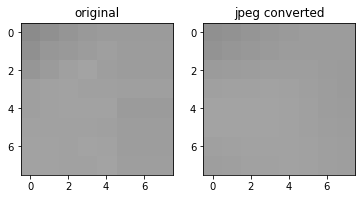

In [120]:
jpeg_test = JPEG(N)
print("restore img")
print("\t no quantize")
#----------------------
plt.subplot(1,2,1)
plt.imshow(img_test,vmin=0, vmax=255)
plt.title("original")
converted_img = jpeg_test.convertToJPEG(img_test)

plt.subplot(1,2,2)
plt.imshow(converted_img,vmin=0,vmax=255)
plt.title("jpeg converted")
plt.show()

(640, 640)
number of dct with zero as its coefficient 0


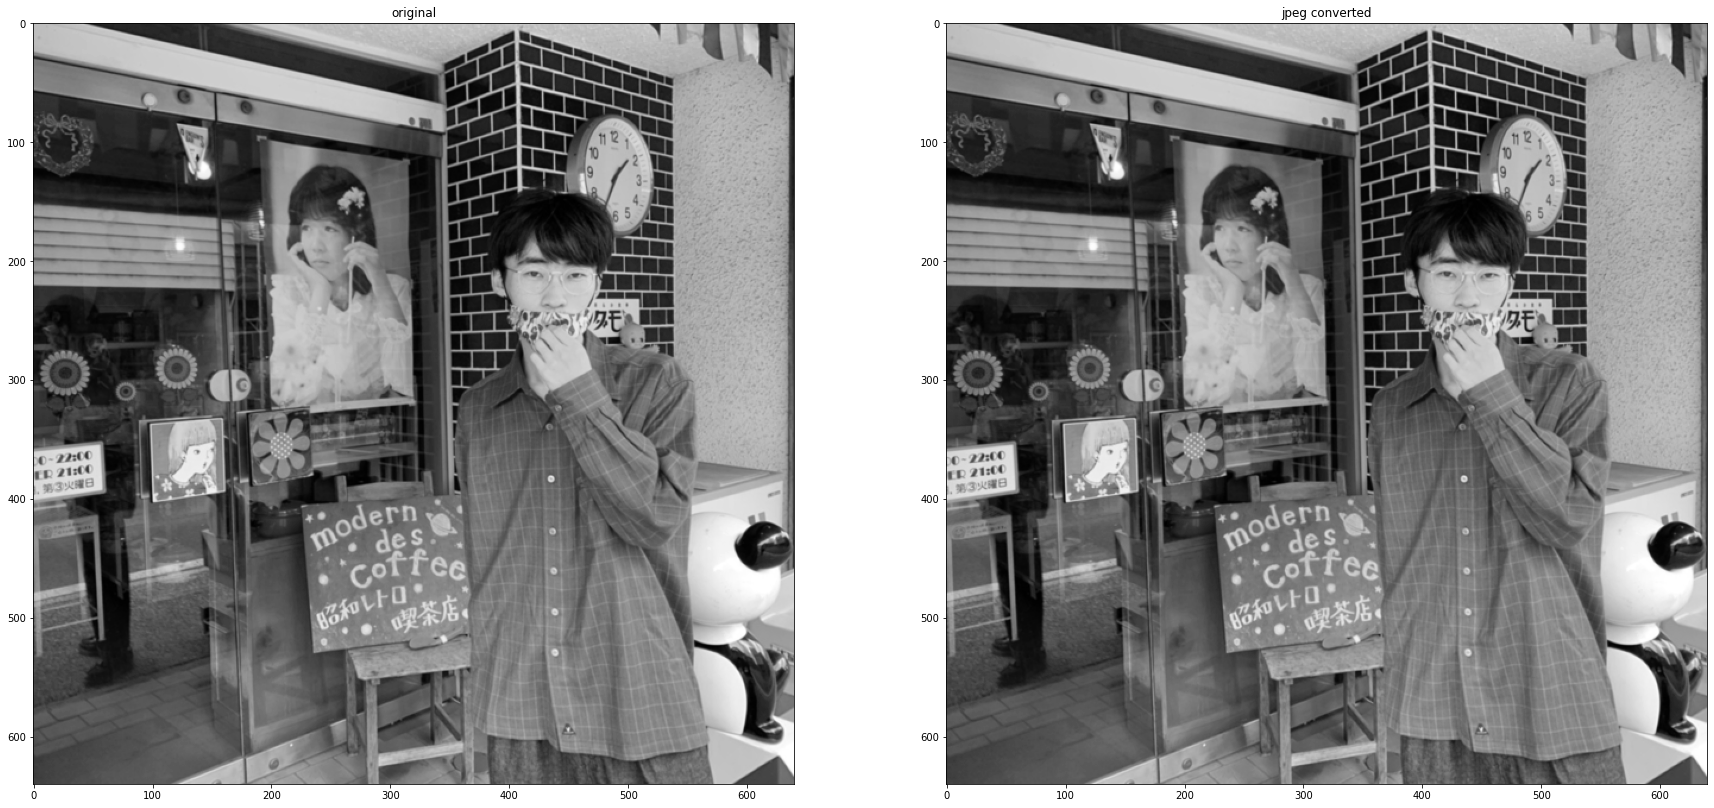

entropy
original : 7.787502544614666
converted : 4.43782200415765
-----------------------------------
number of dct with zero as its coefficient 346628


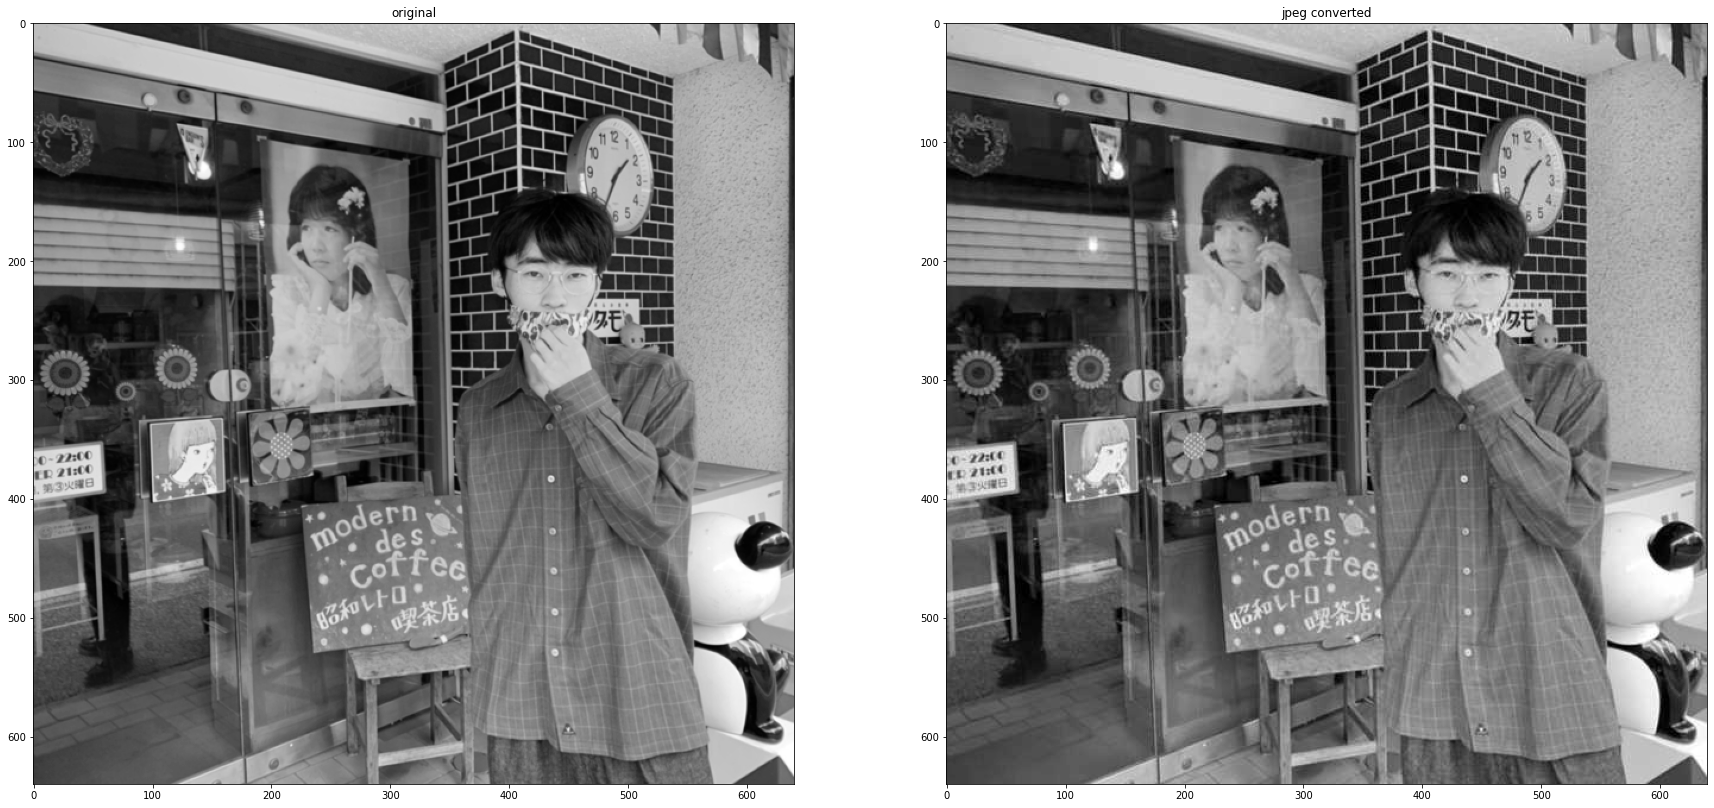

entropy
original : 7.787502544614666
converted : 1.2412423036949511


In [121]:
img = cv2.imread('my_picture.bmp', 0).astype(dtype=int)
ent = calc_entropy(img)
#----------------------
jpeg_no_quantize = JPEG(N)

plt.figure(figsize=(30, 30))
plt.subplot(1,2,1)
plt.imshow(img,vmin=0, vmax=255)
plt.title("original")

converted_img = jpeg_no_quantize.convertToJPEG(img,is_quantize=False)
compressed = jpeg_no_quantize.compressed_img(img,is_quantize=False)
print(compressed.shape)

print("number of dct with zero as its coefficient",jpeg_no_quantize.sparse_num)

plt.subplot(1,2,2)
plt.imshow(converted_img,vmin=0,vmax=255)
plt.title("jpeg converted")
plt.show()

print("entropy")
print("original :",ent)
print("converted :",calc_entropy(compressed,is_compressed=True))

print("-----------------------------------")

#----------------------
img = cv2.imread('my_picture.bmp', 0).astype(dtype=int)
jpeg = JPEG(N)

plt.figure(figsize=(30, 30))
plt.subplot(1,2,1)
plt.imshow(img,vmin=0, vmax=255)
plt.title("original")


converted_img = jpeg.convertToJPEG(img)
compressed = jpeg.compressed_img(img)
print("number of dct with zero as its coefficient",jpeg.sparse_num)
plt.subplot(1,2,2)
plt.imshow(converted_img,vmin=0,vmax=255)
plt.title("jpeg converted")
plt.show()

print("entropy")
print("original :",ent)
print("converted :",calc_entropy(compressed,is_compressed=True))

number of L1 with zero as its coefficient 331369


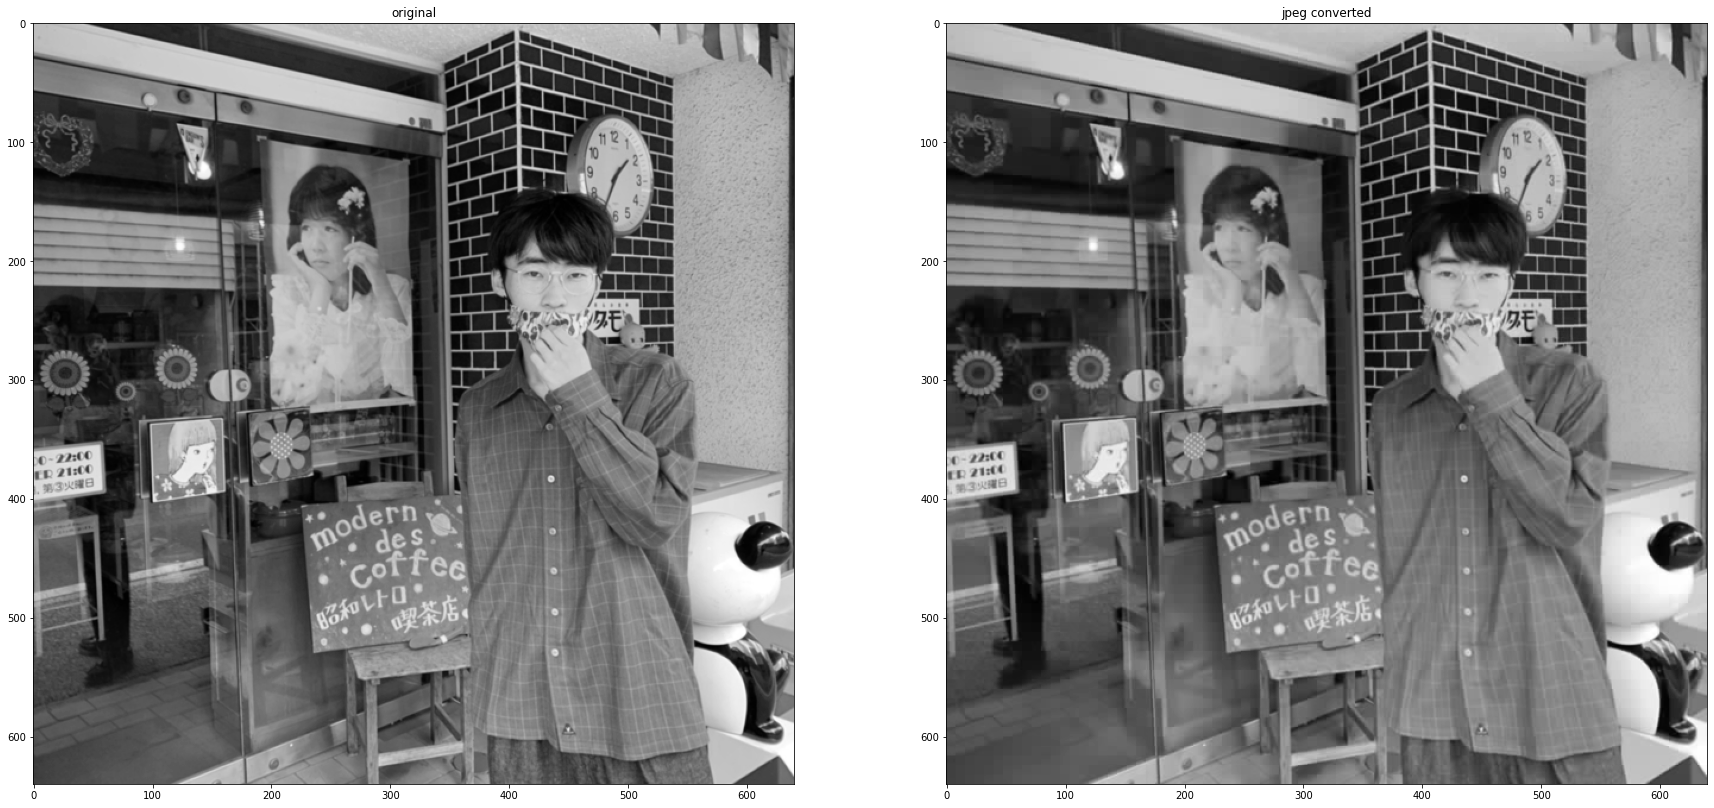

entropy
original : 7.787502544614666
converted : 2.122830534463917


In [122]:
img = cv2.imread('my_picture.bmp', 0).astype(dtype=int)
sparse_no_qunatize = JPEG_sparse(N)

print("restore img L1 norm")
print("\t no quantize")

plt.figure(figsize=(30, 30))
plt.subplot(1,2,1)
plt.imshow(img,vmin=0, vmax=255)
plt.title("original")

converted_img = sparse_no_qunatize.convertToJPEG(img,is_quantize=False)
compressed = sparse_no_qunatize.compressed_img(img,is_quantize=False)
print("number of L1 with zero as its coefficient",sparse_no_qunatize.sparse_num)

plt.subplot(1,2,2)
plt.imshow(converted_img,vmin=0,vmax=255)
plt.title("jpeg converted")
plt.show()

print("entropy")
print("original :",ent)
print("converted :",calc_entropy(compressed,is_compressed=True))

number of L1 with zero as its coefficient 368000


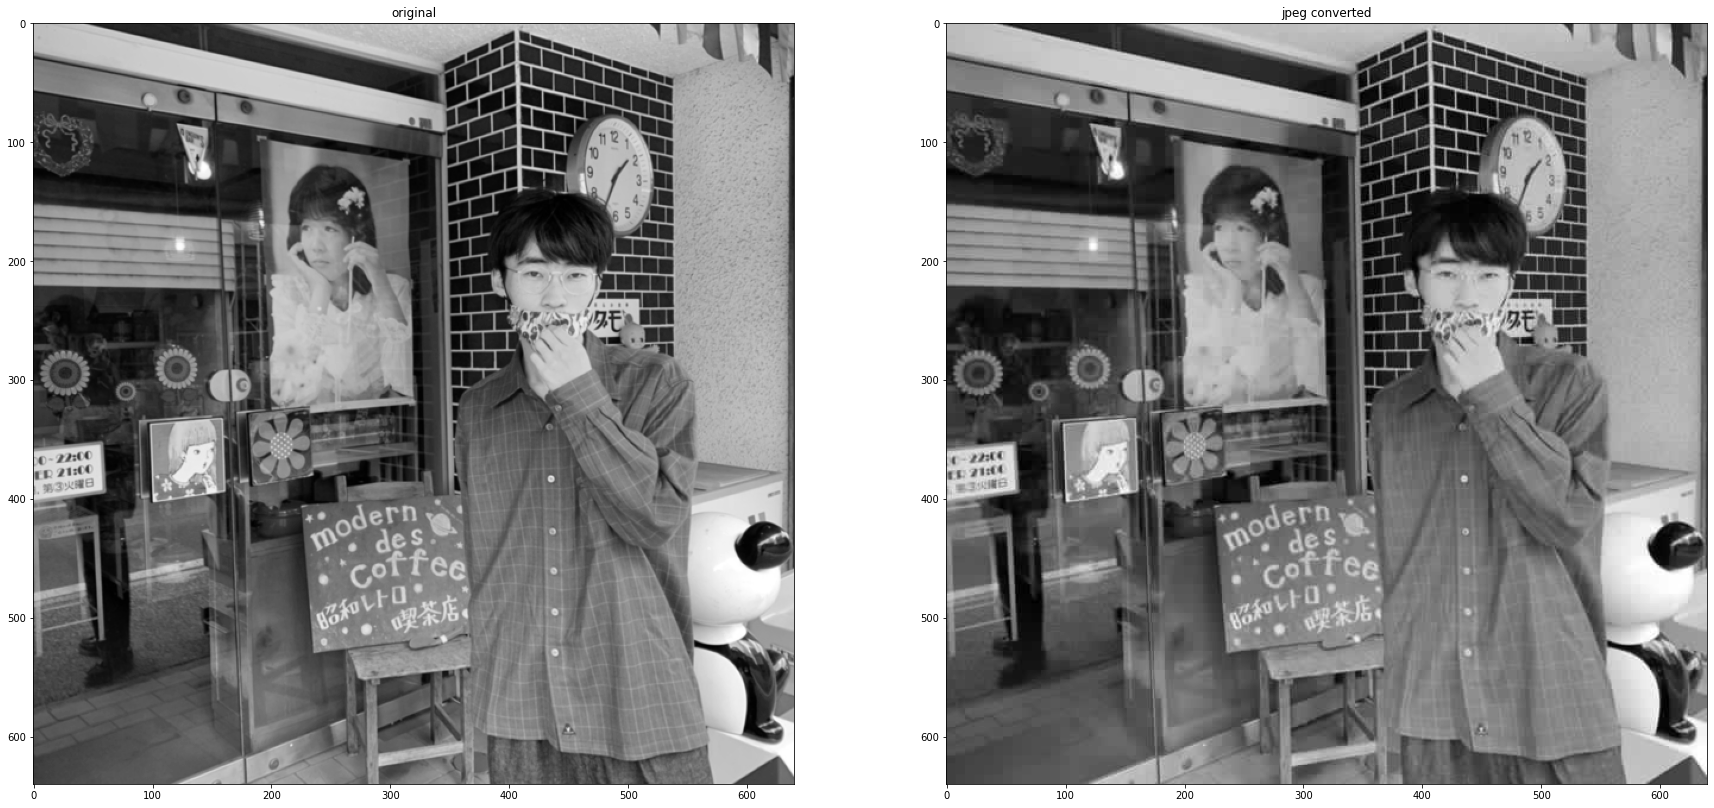

entropy
original : 7.787502544614666
converted : 0.9435560299407015


In [123]:
#----------------------
img = cv2.imread('my_picture.bmp', 0).astype(dtype=int)
sparse = JPEG_sparse(N)
print("\t quantize")

plt.figure(figsize=(30, 30))
plt.subplot(1,2,1)
plt.imshow(img,vmin=0, vmax=255)
plt.title("original")

converted_img = sparse.convertToJPEG(img)
compressed = sparse.compressed_img(img)
print("number of L1 with zero as its coefficient",sparse.sparse_num)

plt.subplot(1,2,2)
plt.imshow(converted_img,vmin=0,vmax=255)
plt.title("jpeg converted")
plt.show()

print("entropy")
print("original :",ent)
print("converted :",calc_entropy(compressed))